# Test daily reward loss
Test the new model to check if it is working correctly.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
#os.environ['MPLCONFIGDIR'] = "$HOME"
#os.envir
# on["WANDB_DIR"] = os.path.join(os.path.dirname(__file__), "..", "wandb")
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
# sys append 
sys.path.append("..")
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from tqdm import tqdm
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
from utils.losses.loss_helpers import log_class_prob_at_t_plus_zt
import sklearn.metrics
import pandas as pd
import wandb
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict
from utils.helpers_training import parse_args_sweep, train_epoch
from utils.helpers_testing import test_epoch
from utils.metrics import harmonic_mean_score
from models.model_helpers import count_parameters, get_t_stop_from_daily_timestamps
import matplotlib.pyplot as plt


## Test the helper functions for the loss

In [3]:
# craete a torch tensor of size (batchsize, sequencelength, nclasses) with random values
batchsize = 1
sequencelength = 5
nclasses = 4

log_class_probabilities = torch.rand((batchsize, sequencelength, nclasses))

# create a tensor of size (batchsize, sequencelength) with random values between 0 and 364
timestamps_left = torch.randint(0, sequencelength-1, (batchsize, sequencelength))


print("log_class_probabilities\n", log_class_probabilities)
print("timestamps_left\n", timestamps_left)

log_class_probab_at_t_plus_zt = log_class_prob_at_t_plus_zt(log_class_probabilities, timestamps_left)
print("log_class_probab_at_t_plus_zt\n", log_class_probab_at_t_plus_zt)

log_class_probabilities
 tensor([[[0.4095, 0.5634, 0.4230, 0.4933],
         [0.5308, 0.6342, 0.9933, 0.8346],
         [0.5927, 0.8360, 0.5476, 0.7770],
         [0.4475, 0.1634, 0.6958, 0.4784],
         [0.7268, 0.8235, 0.0417, 0.8605]]])
timestamps_left
 tensor([[1, 1, 0, 2, 0]])
log_class_probab_at_t_plus_zt
 tensor([[[0.5308, 0.6342, 0.9933, 0.8346],
         [0.5927, 0.8360, 0.5476, 0.7770],
         [0.5927, 0.8360, 0.5476, 0.7770],
         [0.7268, 0.8235, 0.0417, 0.8605],
         [0.7268, 0.8235, 0.0417, 0.8605]]])


## Test the loss

In [4]:
# config 
class Config():
    def __init__(self):
        self.alpha = 0.6
        self.backbonemodel = "LSTM"
        self.batchsize = 256
        self.corrected = True
        self.dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
        self.dataset = "breizhcrops"
        self.device = "cuda"
        self.epochs = 100
        self.epsilon = 10
        self.extra_padding_list = [0]
        self.hidden_dims = 64
        self.learning_rate = 0.001
        self.loss_weight = "balanced"
        self.patience = 30
        self.resume = False
        self.sequencelength = 365
        self.validation_set = "valid"
        self.weight_decay = 0
        self.daily_timestamps = True
        self.original_time_serie_lengths = [102]
        self.loss = "daily_reward_loss"
        
config = Config()

In [5]:
dataroot = os.path.join(config.dataroot,"breizhcrops")
input_dim = 13
test_ds = BreizhCrops(root=dataroot,partition=config.validation_set, sequencelength=config.sequencelength, corrected=config.corrected, daily_timestamps=config.daily_timestamps, original_time_serie_lengths=config.original_time_serie_lengths)
train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=config.sequencelength, corrected=config.corrected, daily_timestamps=config.daily_timestamps, original_time_serie_lengths=config.original_time_serie_lengths)
nclasses = train_ds.nclasses
class_names = train_ds.labels_names
traindataloader = DataLoader(train_ds,batch_size=config.batchsize)
testdataloader = DataLoader(test_ds, batch_size=config.batchsize)

2559635960 2559635960


loading data into RAM: 100%|██████████| 67523/67523 [00:30<00:00, 2230.23it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:34<00:00, 2460.52it/s]


cost function: 

model: 

In [6]:
model = DailyEarlyRNN(config.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=config.sequencelength, hidden_dims=config.hidden_dims).to(config.device)


optimizer

In [7]:
# exclude decision head linear bias from weight decay
decay, no_decay = list(), list()
for name, param in model.named_parameters():
    if name == "stopping_decision_head.projection.0.bias":
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = torch.optim.AdamW([{'params': no_decay, 'weight_decay': 0, "lr": config.learning_rate}, {'params': decay}],
                                lr=config.learning_rate, weight_decay=config.weight_decay)



loss: 

In [8]:
if config.loss_weight == "balanced":
    class_weights = train_ds.get_class_weights().to(config.device)
else: 
    class_weights = None

if config.loss == "early_reward":
    criterion = EarlyRewardLoss(alpha=config.alpha, epsilon=config.epsilon, weight=class_weights)
elif config.loss == "stopping_time_proximity":
    criterion = StoppingTimeProximityLoss(alphas=config.alphas, weight=class_weights)
elif config.loss == "daily_reward_loss":
    criterion = DailyRewardLoss(alpha=config.alpha, weight=class_weights)

Train example

In [9]:
# ----------------------------- TRAINING -----------------------------
start_epoch = 1
print("starting training...")
with tqdm(range(start_epoch, config.epochs + 1)) as pbar:
    for epoch in pbar:
        dict_epoch = {"epoch": epoch}
        trainloss = train_epoch(model, traindataloader, optimizer, criterion, device=config.device, **dict_epoch)
        testloss, stats = test_epoch(model, testdataloader, criterion, config.device, return_id=test_ds.return_id, daily_timestamps=config.daily_timestamps, **dict_epoch)
        break
    
        # plot timestamps left
        fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
        plot_timestamps_left(stats, ax_timestamps, fig_timestamps)
        
        # statistic logging and visualization...
        precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(
            y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0], average="macro",
            zero_division=0)
        accuracy = sklearn.metrics.accuracy_score(
            y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0])
        kappa = sklearn.metrics.cohen_kappa_score(
            stats["predictions_at_t_stop"][:, 0], stats["targets"][:, 0])

        classification_loss = stats["classification_loss"].mean()
        earliness_reward = stats["earliness_reward"].mean()
        earliness = 1 - (stats["t_stop"].mean() / (config.sequencelength - 1))
        harmonic_mean = harmonic_mean_score(accuracy, stats["classification_earliness"])

starting training...


  0%|          | 0/100 [03:47<?, ?it/s]


In [10]:
stats["timestamps_left"].shape

(67523, 365)

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Timestamps left'}, xlabel='day of year', ylabel='timestamps left'>)

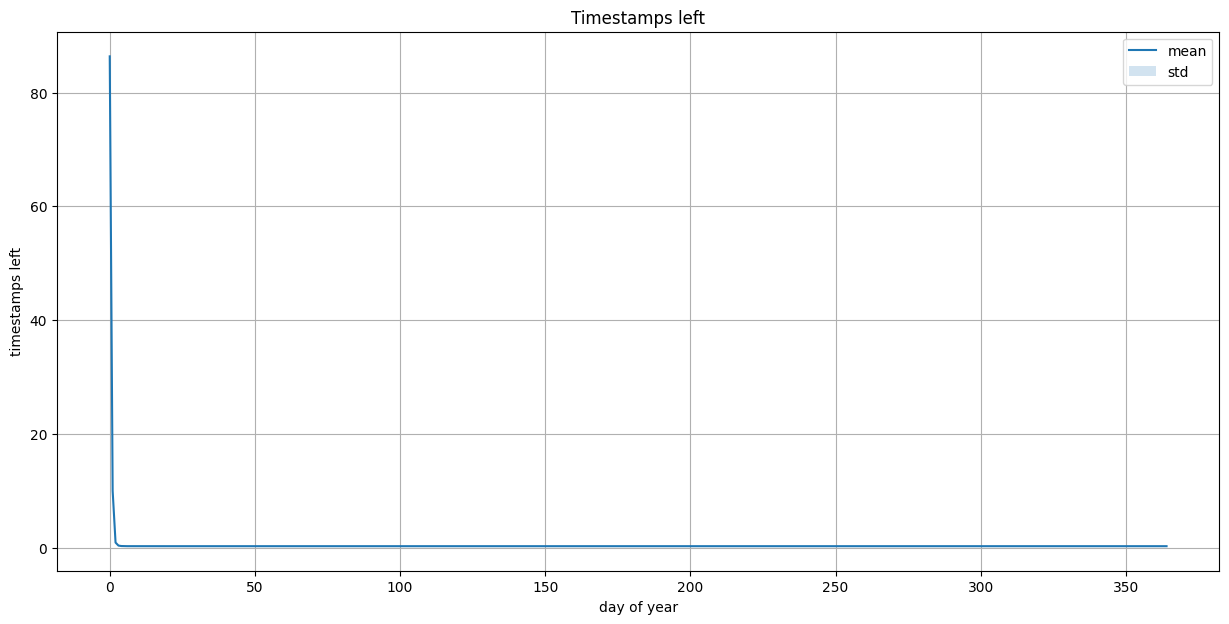

In [11]:
def plot_timestamps_left(stats, ax_timestamps, fig_timestamps):
    timestamps_left_mean = stats["timestamps_left"].mean(axis=0)
    timestamps_left_std = stats["timestamps_left"].std(axis=0)
    # plot mean and std
    ax_timestamps.plot(timestamps_left_mean, label="mean")
    ax_timestamps.fill_between(range(len(timestamps_left_mean)), timestamps_left_mean - timestamps_left_std,
                              timestamps_left_mean + timestamps_left_std, alpha=0.2, label="std")
    ax_timestamps.set_xlabel("day of year")
    ax_timestamps.set_ylabel("timestamps left")
    ax_timestamps.set_title("Timestamps left")
    ax_timestamps.legend()
    ax_timestamps.grid()
    
    return fig_timestamps, ax_timestamps


fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
plot_timestamps_left(stats, ax_timestamps, fig_timestamps)

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

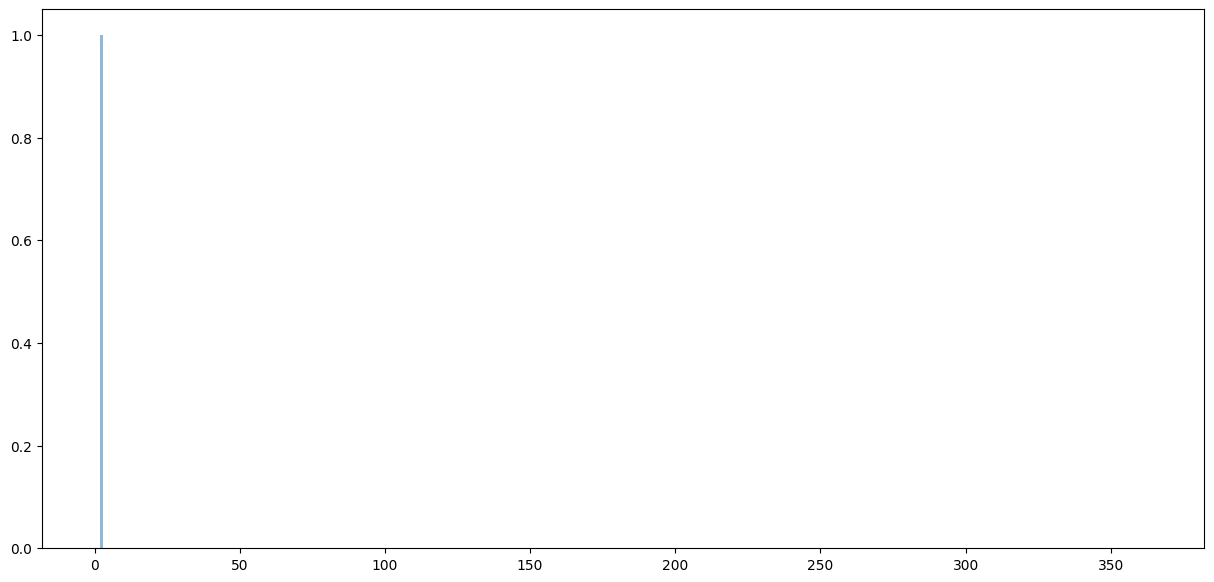

In [12]:
timestamps_left = stats["timestamps_left"]
# to torch tensor
timestamps_left = torch.from_numpy(timestamps_left)
t_stop = get_t_stop_from_daily_timestamps(timestamps_left, threshold=5)

# plot t_stop distribution
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(t_stop, bins=range(0, config.sequencelength), density=True, alpha=0.5, label="t_stop")

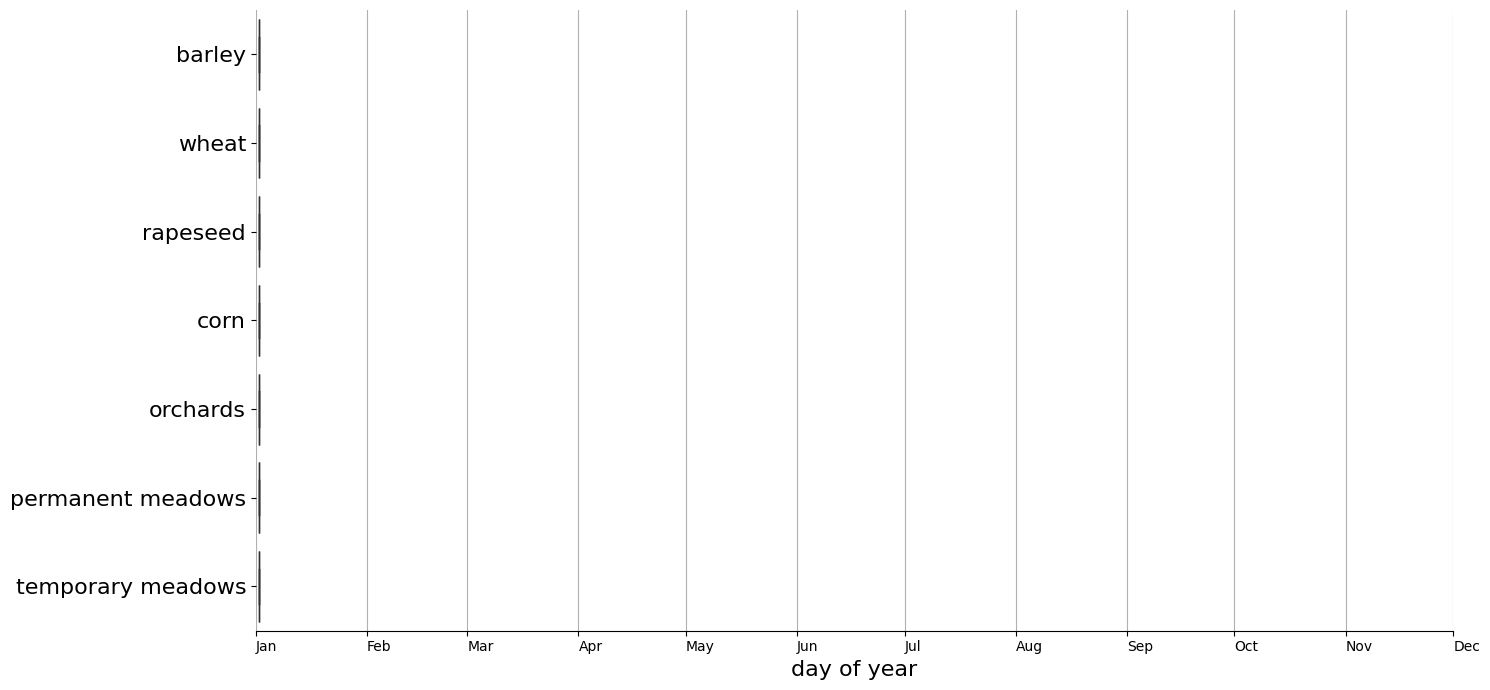

In [13]:
doys_stop = stats["t_stop"].squeeze()
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

In [14]:
# dummy test for get_t_stop_from_daily_timestamps
# create daily_timestamps tensor, with only zeros 
daily_timestamps = torch.zeros((batchsize, config.sequencelength), dtype=torch.float)
print("daily_timestamps", daily_timestamps)
t_stop = get_t_stop_from_daily_timestamps(daily_timestamps, threshold=5)
print("t_stop", t_stop)


daily_timestamps tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0